# Environments
<a id='environments'></a>

By default, there are 5 off-the-shelf RL environments:
- Generalization environment
- VaryingDynamics environment
- Safe RL environment
- MARL environment
- Real-world environment


## Generalization Environment

<iframe width="656" height="369" src="https://www.youtube.com/embed/hL0XDfNHYjA?si=7cn1CpzgpNAf8OAd" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

We developed an RL environment through procedural generation where maps are composed by connecting various types of road blocks and then traffic vehicles are scattered on maps randomly.
Thus the environment can generate an unlimited number of diverse driving scenarios.
By training RL agents in one set of scenarios and testing them in another held-out set, we can benchmark the generalizability of the driving policy. 


<img src="figs/blocks_and_big_case_page.jpg" width="600" class="center">


The following script creates basic environments that can be used for such purpose:


In [ ]:
from metadrive import MetaDriveEnv
import tqdm

training_env = MetaDriveEnv(dict(
    num_scenarios=1000,
    start_seed=1000,
    random_lane_width=True,
    random_agent_model=True,
    random_lane_num=True
))


test_env = MetaDriveEnv(dict(
    num_scenarios=200,
    start_seed=0,
    random_lane_width=True,
    random_agent_model=True,
    random_lane_num=True
))


User can specify the training set with 1000 driving scenarios by setting `num_scenarios=1000` and `start_seed=1000`, while creating the test set by setting `num_scenarios=200` and `start_seed=0`.
In this case, the scenarios generated by random seeds [1000, 1999] will be used to train the agents and those by [0, 199] will be used to test the trained agent.

**Note: Please note that each process should only have one single MetaDrive instance due to the limit of the underlying simulation engine, but sometimes we want to have one environment for training and the other one for testing.** There are two ways to overcome this:
1. Launching the training environment and test environment in two separate processes using tools like `Ray` or `stablebaseline3.SubprocVecEnv`. Generally, We use [Ray/RLLib](https://docs.ray.io/en/latest/rllib.html) to train RL agents. The training and test environments are naturally hosted in training workers (processes) and evaluation workers. Therefore we do not worry about this singleton problem.
2. Closing the training environment `training_env.close()` before launch the test environment via `test_env.reset()`. After evaluation, it is allowed to restore the training environment after closing the test environment by simply `training_env.reset()`. An example is as follows.

In [ ]:
for training_epoch in range(2):
    # training
    training_env.reset()
    print("\nStart fake training epoch {}...".format(training_epoch))
    for _ in range(10):
        # execute 10 step
        training_env.step(training_env.action_space.sample())
    training_env.close()

    # evaluation
    print("Evaluate checkpoint for training epoch {}...\n".format(training_epoch))
    test_env.reset()
    for _ in range(10):
        # execute 10 evaluation step
        test_env.step(test_env.action_space.sample())
    test_env.close()

assert test_env.config is not training_env.config

### Randomization

The other config `dict(random_lane_width=True, random_agent_model=True, random_lane_num=True)` specifies if the agent model, lane num and lane width will be randomized to make the scenarios more diverse. In the following example, we sample 50 scenarios from the training set and show the statistics.

In [9]:
from metadrive.component.vehicle.vehicle_type import vehicle_type

# container
env_seed=1000
lane_nums = set()
lane_widths = set()
vehicle_models = set()
traffic_vehicle_models = set()

# collect statistics
maps_to_sample = 50
end_seed = training_env.config["start_seed"] + maps_to_sample
for env_seed in tqdm.tqdm(range(training_env.config["start_seed"], end_seed)):
    
    # use `seed` argument to choose which scenario to run
    training_env.reset(seed=env_seed)
    lane_nums.add(training_env.current_map.config["lane_num"]) 
    lane_widths.add(training_env.current_map.config["lane_width"])
    vehicle_models.add(training_env.vehicle.__class__.__name__)
    traffic_models = set([obj.__class__ for obj in training_env.engine.traffic_manager.spawned_objects.values()])
    traffic_vehicle_models = traffic_vehicle_models.union(traffic_models)
    assert vehicle_type[training_env.vehicle.config["vehicle_model"]] is training_env.vehicle.__class__
    
training_env.close()

# show information
print("Number of lanes in {} maps are: {}".format(maps_to_sample, lane_nums))
print("{} maps have {} different widths".format(maps_to_sample, len(lane_widths)))
print("The policy is learning to drive {} types of vehicles".format(len(vehicle_models)))
print("There are {} types of traffic vehicles".format(len(traffic_vehicle_models)))

# check
assert lane_nums == {2, 3}
assert len(lane_widths) == 50
assert len(vehicle_models) == 5
assert len(traffic_vehicle_models) == len(vehicle_models) - 1

  0%|                                                                                                                                                                                | 0/50 [00:00<?, ?it/s][INFO] Assets version: 0.4.1.2
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 1000, Num Scenarios : 1000
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.31it/s]

Number of lanes in 50 maps are: {2, 3}
50 maps have 50 different widths
The policy is learning to drive 5 types of vehicles
There are 4 types of traffic vehicles


There are more config terms for customizing this environment. The full config with comprehensive annotations is at [METADRIVE_DEFAULT_CONFIG](https://github.com/metadriverse/metadrive/blob/main/metadrive/envs/metadrive_env.py#L18).
Most of the fields are configuration for the reward, cost, termination function, while some of them can be changed to customize the environment. 

### Traffic

The first important field is `traffic_density`. The default value is `0.1`. Increasing this value will make the traffic flow dense. **Note: there is not an obvious relationship between this value and the number of vehicles.** The following code calculates the average number of vehicles in environments with different `traffic_density`. We also turn off the logging, so you won't see any `[INFO]` level messages.

In [10]:
from metadrive import MetaDriveEnv
import tqdm
import logging

simple_env = MetaDriveEnv(dict(num_scenarios=10, start_seed=0, log_level=logging.WARNING)) # Default, traffic density=0.1
complex_env = MetaDriveEnv(dict(num_scenarios=10, start_seed=0, traffic_density=0.5, log_level=logging.WARNING))

def calculate_traffic_vehicles(env, name):
    num_v = 0
    for seed in range(10):
        env.reset(seed=seed)
        num_v += len(env.engine.traffic_manager.spawned_objects)
    print("There are averagely {} vehicles in {}".format(num_v/10, name))
    env.close()

calculate_traffic_vehicles(simple_env, "environment with 0.1 density")
calculate_traffic_vehicles(complex_env, "environment with 0.5 density")

There are averagely 8.0 vehicles in environment with 0.1 density
There are averagely 43.4 vehicles in environment with 0.5 density


To maximize the interaction between ego car and traffic vehicles. The default traffic mode is `trigger`. In this mode, the traffic vehicles are scattered and keep static on the map and will be triggered to move only when the ego car is close to them. After the traffic vehicles reach the destination, they will be deleted from the scene. In the following example, the traffic vehicles in the roundabout are triggered when the `step > 100` and the ego car enters the roundabout. It also demonstrates how to use top-down renderer. More details can be found at [Top-down renderer](top_down_render.ipynb).

In [ ]:
from metadrive import MetaDriveEnv
from metadrive.policy.idm_policy import IDMPolicy

env = MetaDriveEnv(dict(traffic_mode="trigger", map="O")) # Default, traffic density=0.1
env.reset(seed=0)
try:
    for i in range(1000):
        o,r,d,_,_ = env.step([0,-0.2] if i < 100 or i> 150 else [0, 0.2])
        env.render(mode="topdown", 
                   scaling=4, 
                   camera_position=(100, 0), 
                   text={"episode_step": env.engine.episode_step})
finally:
    env.close()

By changing the mode to `respawn`, the cars will be added into the scene at some places called spawn point when the scenario is initialized and move to their destination right now. After reaching the goal point and being recycled, they will be spawned again at the spawn points. 

In [ ]:
from metadrive import MetaDriveEnv

env = MetaDriveEnv(dict(traffic_mode="respawn", map="O", traffic_density=0.05)) # Default, traffic density=0.1
env.reset(seed=0)
try:
    for _ in range(1000):
        o,r,d,_,_ = env.step([0,0.0])
        env.render(mode="topdown", scaling=4, camera_position=(100, 0))
finally:
    env.close()

There is also a mode called `hybrid` allows to allow respawning cars in the `trigger` mode.

In [ ]:
from metadrive import MetaDriveEnv
from metadrive.policy.idm_policy import IDMPolicy

env = MetaDriveEnv(dict(traffic_mode="hybrid", map="O")) # Default, traffic density=0.1
env.reset(seed=0)
try:
    for i in range(1000):
        o,r,d,_,_ = env.step([0,0.2] if i > 100 and i < 200 else [0, -0.5])
        env.render(mode="topdown", scaling=4, camera_position=(100, 0))
finally:
    env.close()

### Map

The other important fields are map-related ones. It allows you to adjust map properties like the number of lanes and the structures. The full map config is
```python
map_config={
    BaseMap.GENERATE_TYPE: MapGenerateMethod.BIG_BLOCK_NUM, 
    BaseMap.GENERATE_CONFIG: None,  # it can be a file path / block num / block ID sequence
    BaseMap.LANE_WIDTH: 3.5,
    BaseMap.LANE_NUM: 3,
},
```

The following example show how to change the map with these configs. The first row shows maps generated with 3 blocks; The second row shows maps generated with 5 blocks; The last row shows maps generated with 5 blocks where each road has 4 lanes. As these maps are generated with the same random seed, in each column, each map is a part of another larger one or has a similar structure with another.   

In [ ]:
from metadrive import MetaDriveEnv
from metadrive.component.map.base_map import BaseMap
from metadrive.policy.idm_policy import IDMPolicy
from metadrive.component.map.pg_map import MapGenerateMethod
import matplotlib.pyplot as plt
from metadrive import MetaDriveEnv
from metadrive.utils.draw_top_down_map import draw_top_down_map
import logging

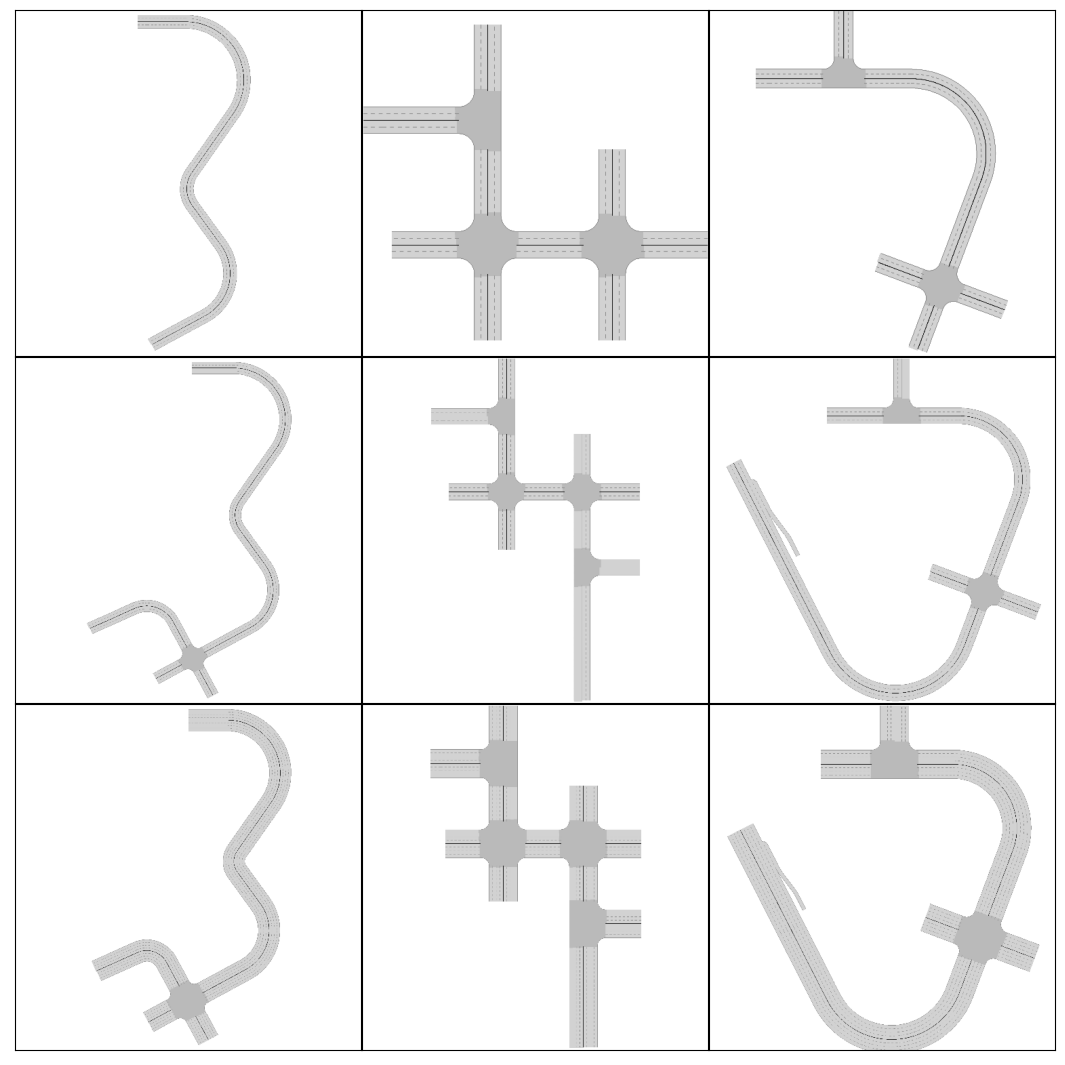

In [7]:
map_config={BaseMap.GENERATE_TYPE: MapGenerateMethod.BIG_BLOCK_NUM, 
            BaseMap.GENERATE_CONFIG: 3,  # 3 block
            BaseMap.LANE_WIDTH: 3.5,
            BaseMap.LANE_NUM: 2}

fig, axs = plt.subplots(3, 3, figsize=(10, 10), dpi=200)
plt.tight_layout(pad=-3)

for i in range(3):
    if i==0:
        map_config["config"]=3
        env = MetaDriveEnv(dict(num_scenarios=10, map_config=map_config, log_level=logging.WARNING))
    elif i==1:
        map_config["config"]=5
        env = MetaDriveEnv(dict(num_scenarios=10, map_config=map_config, log_level=logging.WARNING))
    elif i==2:
        map_config["config"]=5
        map_config["lane_num"]=4
        env = MetaDriveEnv(dict(num_scenarios=10, map_config=map_config, log_level=logging.WARNING))
    for j in range(3):
        env.reset(seed=j)
        m = draw_top_down_map(env.current_map)
        ax = axs[i][j]
        ax.imshow(m, cmap="bone")
        ax.set_xticks([])
        ax.set_yticks([])
    env.close()
plt.show()

You can also specify the shape of the map with `BaseMap.GENERATE_TYPE=MapGenerateMethod.BLOCK_SEQUENCE`. Block sequence is a string with character selected from `X, O, S, T, r, R, C`, representing respectively intersection, roundabout, straight road, T-intersection, in-ramp, out-ramp and curve road. The number of block equals to the length of the string to specify the block sequence. The following example shows how to generate maps with a fixed block sequence. 

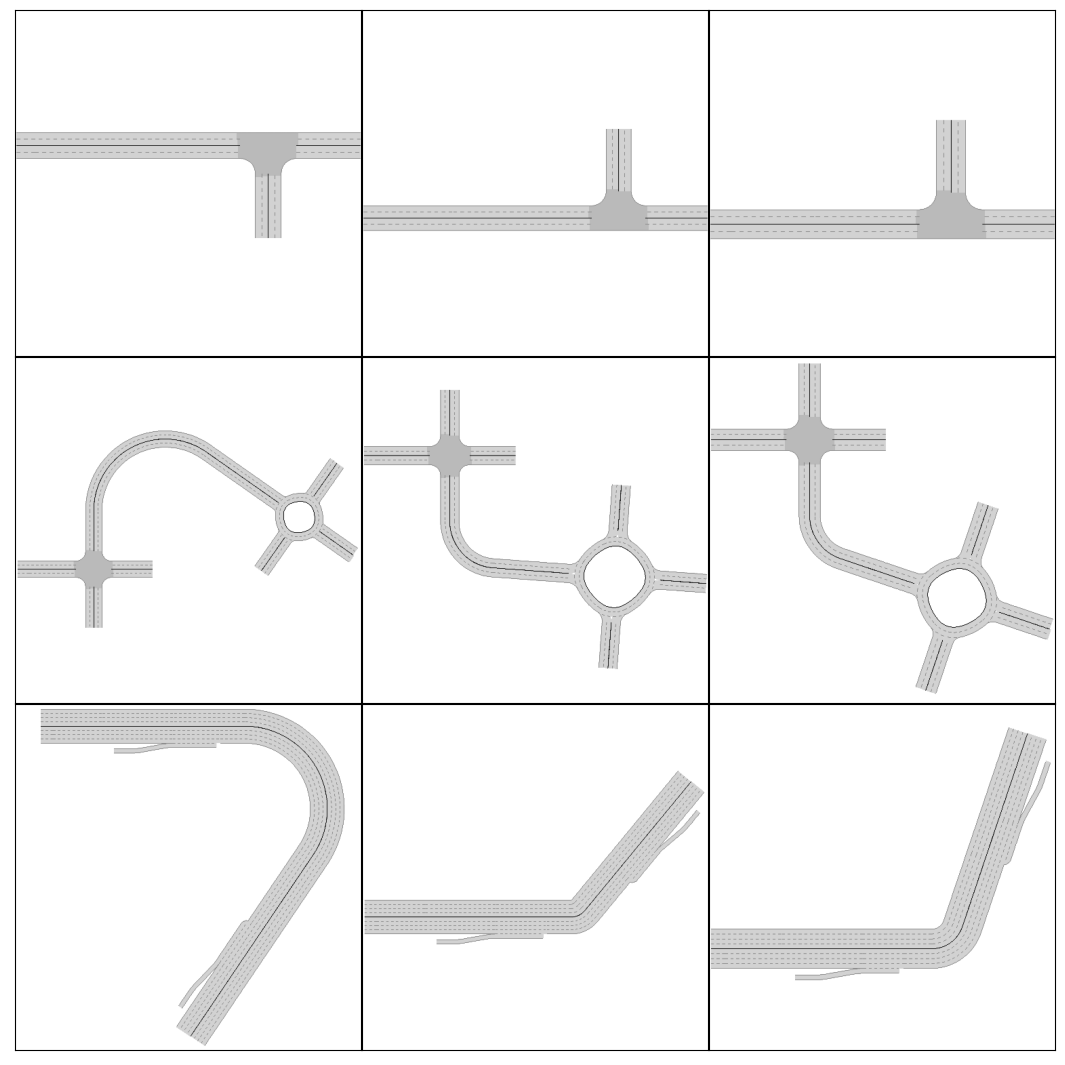

In [8]:
map_config={BaseMap.GENERATE_TYPE: MapGenerateMethod.BIG_BLOCK_SEQUENCE, 
            BaseMap.GENERATE_CONFIG: "XOS",  # 3 block
            BaseMap.LANE_WIDTH: 3.5,
            BaseMap.LANE_NUM: 2}

fig, axs = plt.subplots(3, 3, figsize=(10, 10), dpi=200)
plt.tight_layout(pad=-3)

for i in range(3):
    if i==0:
        map_config["config"]="ST"
        env = MetaDriveEnv(dict(num_scenarios=10, map_config=map_config, log_level=logging.WARNING))
    elif i==1:
        map_config["config"]="XCO"
        env = MetaDriveEnv(dict(num_scenarios=10, map_config=map_config, log_level=logging.WARNING))
    elif i==2:
        map_config["config"]="rCR"
        map_config["lane_num"]=4
        env = MetaDriveEnv(dict(num_scenarios=10, map_config=map_config, log_level=logging.CRITICAL))
    for j in range(3):
        env.reset(seed=j)
        m = draw_top_down_map(env.current_map)
        ax = axs[i][j]
        ax.imshow(m, cmap="bone")
        ax.set_xticks([])
        ax.set_yticks([])
    env.close()
plt.show()

If you only want to change the map structures, you don't need to set the complex `map_config`. You can use `map` to quickly configure it. If the value of `map` is a number, the map generation method would be `BIG_BLOCK_NUM`. If the value is a string, the map generation method would be `BIG_BLOCK_SEQUENCE`. In the following example, maps in the first row are composed with 5 blocks, while the maps in the second row are all composed with a roundabout and a curve road.

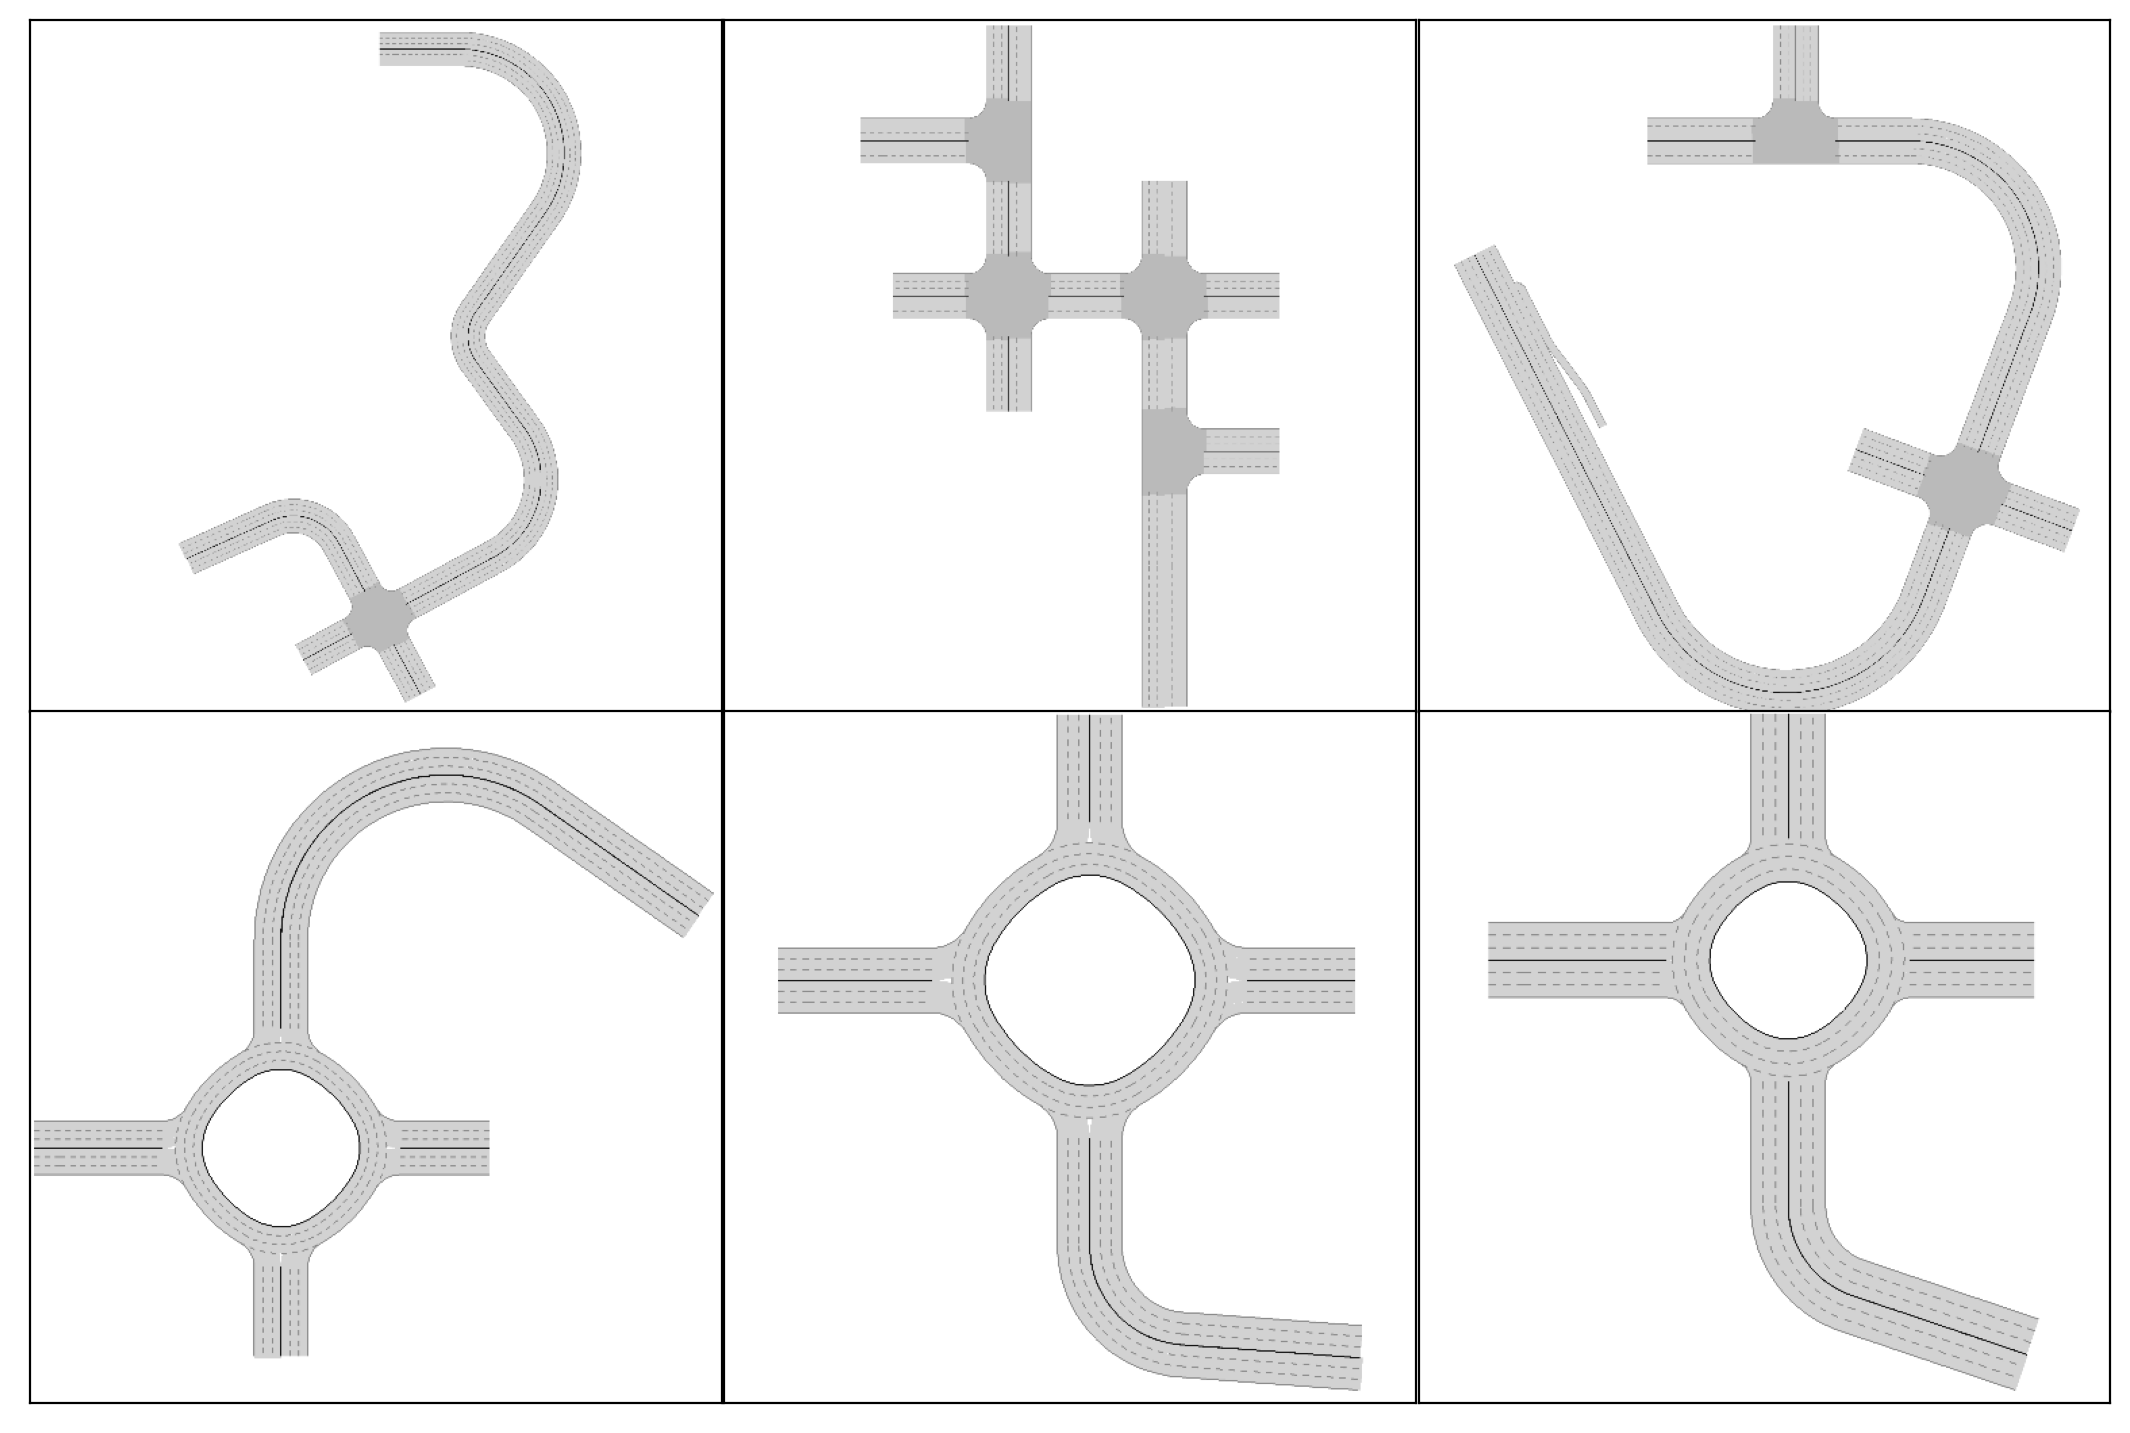

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6.5), dpi=200)
plt.tight_layout(pad=-3)

for i in range(2):
    if i==0:
        env = MetaDriveEnv(dict(num_scenarios=10, map=5, log_level=logging.WARNING))
    elif i==1:
        map_config["config"]="XCO"
        env = MetaDriveEnv(dict(num_scenarios=10, map="OC", log_level=logging.WARNING))
    for j in range(3):
        env.reset(seed=j)
        m = draw_top_down_map(env.current_map)
        ax = axs[i][j]
        ax.imshow(m, cmap="bone")
        ax.set_xticks([])
        ax.set_yticks([])
    env.close()
plt.show()

## VaryingDynamics Environment
Actually, we provide an upgraded version for generalization environment with full PG functionality and can additionally randomize the dynamics of ego vehicle.
The environment is called `VaryingDynamicsEnv` and you can control the `random_dynamics` dict in the config
to adjust the randomizing range of specific dynamics parameters.
In the below example (which is also the default config), we randomize the dynamics of vehicle to the lowest and highest limit we recommended.

In [4]:
from metadrive.envs.varying_dynamics_env import VaryingDynamicsEnv
from metadrive.component.vehicle.vehicle_type import vehicle_type
import tqdm
import logging

training_env = VaryingDynamicsEnv(dict(
        num_scenarios=1000,  
        
        # Stop randomizing them
        # random_lane_width=True,
        # random_agent_model=True,
        # random_lane_num=True
    
        # We will sample each parameter from (min_value, max_value)
        # You can set it to None to stop randomizing the parameter.
        random_dynamics=dict(
            max_engine_force=(100, 3000),
            max_brake_force=(20, 600),
            wheel_friction=(0.1, 2.5),
            max_steering=(10, 80),  # The maximum steering angle if action = +-1
            mass=(300, 3000)
        ),
        log_level=logging.WARNING
    ))

In [41]:
env_seed=1000
lane_nums = set()
lane_widths = set()
vehicle_models = set()
traffic_vehicle_models = set()

# collect statistics
to_collect_set = {k: set() for k in ["max_engine_force", 
                                     "max_brake_force", 
                                     "wheel_friction", 
                                     "max_steering", 
                                     "mass"]}

maps_to_sample = 50
end_seed = training_env.config["start_seed"] + maps_to_sample
for env_seed in range(training_env.config["start_seed"], end_seed):
    
    # use `seed` argument to choose which scenario to run
    training_env.reset(seed=env_seed)
    lane_nums.add(training_env.current_map.config["lane_num"]) 
    lane_widths.add(training_env.current_map.config["lane_width"])
    vehicle_models.add(training_env.vehicle.__class__.__name__)
    traffic_models = set([obj.__class__ for obj in training_env.engine.traffic_manager.spawned_objects.values()])
    traffic_vehicle_models = traffic_vehicle_models.union(traffic_models)
    assert vehicle_type[training_env.vehicle.config["vehicle_model"]] is training_env.vehicle.__class__
    
    # collect more
    for k, v in to_collect_set.items():
        v.add(training_env.vehicle.config[k])
    
training_env.close()

print("Number of lanes in {} maps are: {}".format(maps_to_sample, lane_nums))
print("{} maps have {} different widths".format(maps_to_sample, len(lane_widths)))
print("The policy is learning to drive vehicles with {} different dyamics".format(len(to_collect_set["wheel_friction"])))

assert all([len(s)==50 for s in to_collect_set.values()])
assert lane_nums == {3}
assert len(lane_widths) == 1
assert vehicle_models == set([vehicle_type["varying_dynamics"].__name__])
assert len(traffic_vehicle_models) == 4

Number of lanes in 50 maps are: {3}
50 maps have 1 different widths
The policy is learning to drive vehicles with 50 different dyamics


### Wheel Friction Example

In the very early stage of MetaDrive, we have experimented randomizing the `wheel_friction` in the training environment.
We find that `wheel_friction > 1.2` makes little impact to the performance. So you can try a training environment
with `wheel_friction in [1.0, 1.4)` and test the trained agent in `wheel_friction in [0.6, 1.0)`.
The training environment is significantly easier than the test environment.
We are expecting that the agent trained in less training scenarios will perform poorly in the test environment.
The following example shows two episode with different `wheel_friction`. It is obvious that the car with high `wheel_friction` can pass the curve roads, while the car with low `wheel_friction` fails.

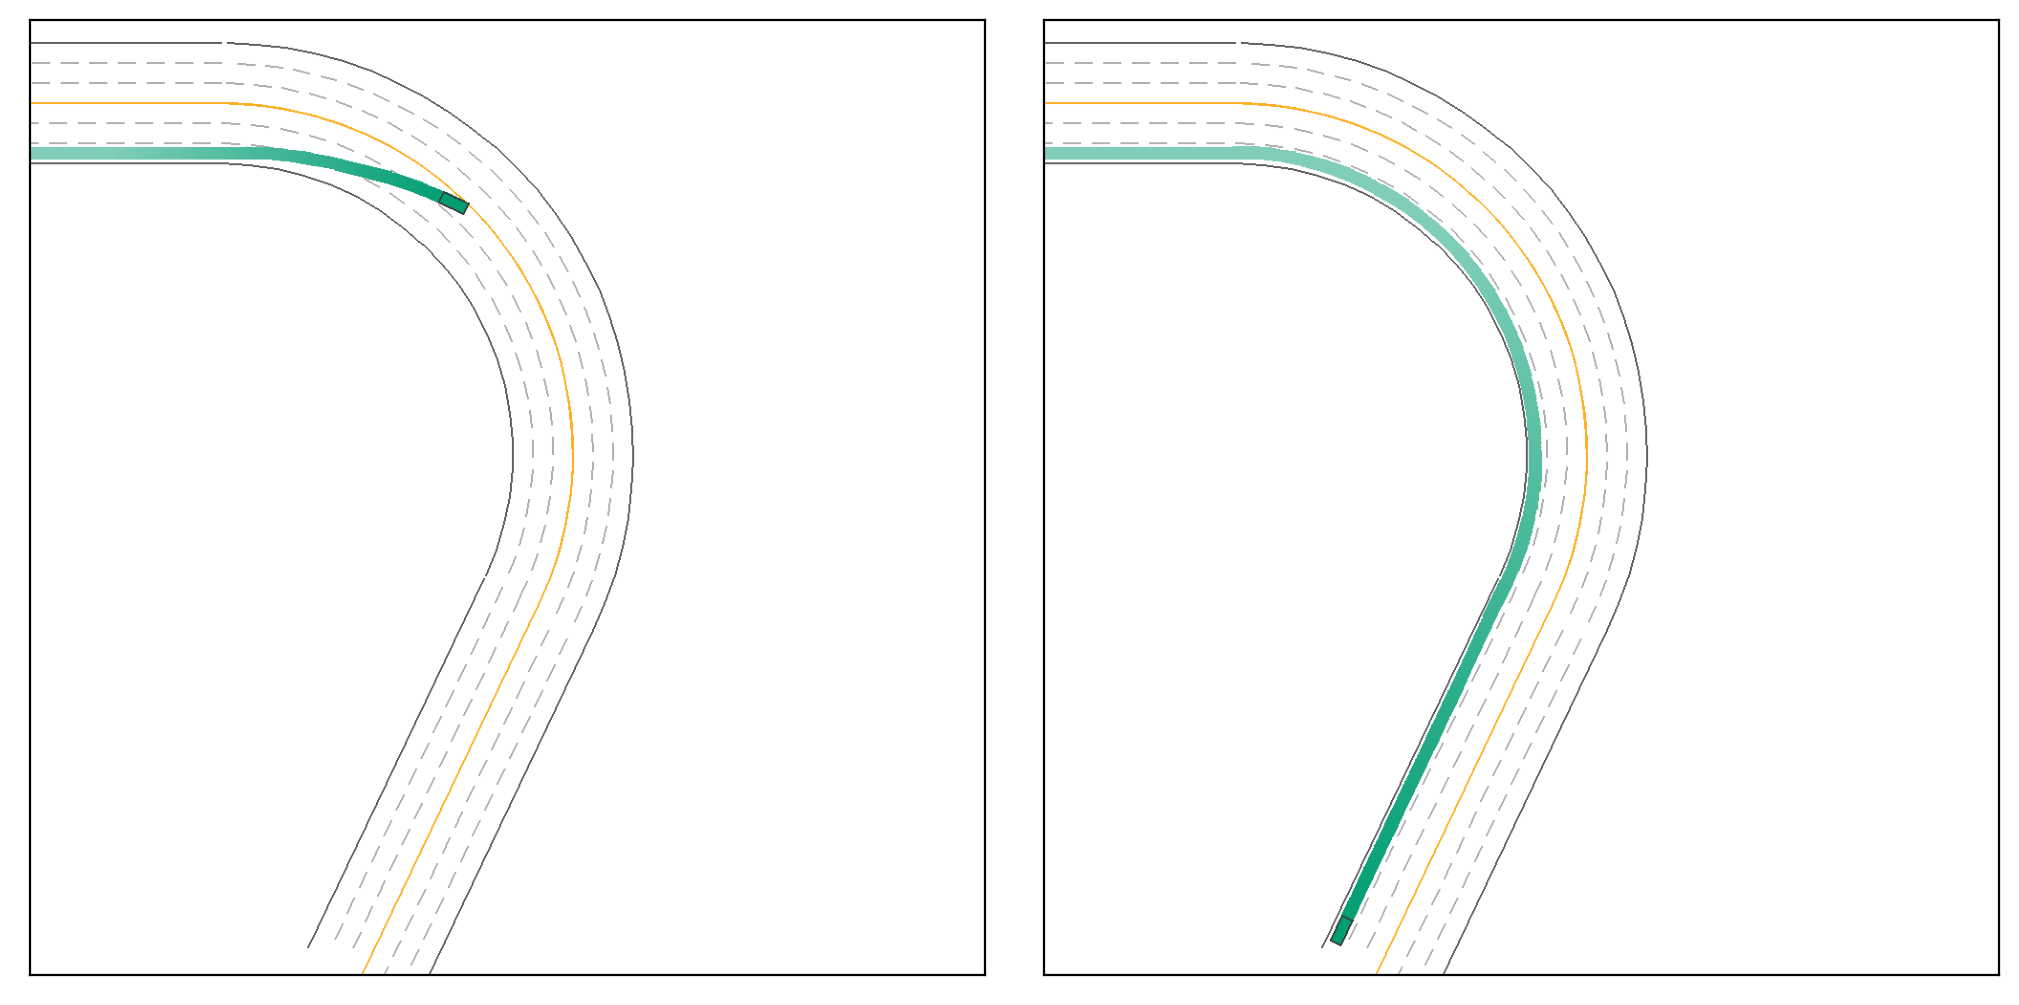

In [5]:
from metadrive.policy.idm_policy import IDMPolicy
import pygame
import matplotlib.pyplot as plt


def run_env(friction):
    env = VaryingDynamicsEnv(dict(num_scenarios=1, 
                                  traffic_density=0,
                                  agent_policy=IDMPolicy,
                                  map="C",
                                  random_dynamics=dict(wheel_friction=(friction, friction)),
                                  log_level=logging.WARNING))
    env.reset(seed=0)
    try:
        for i in range(1000):
            o,r,d,_,info = env.step([0,0])
            surface=env.render(mode="topdown", scaling=6, camera_position=(100, -60), draw_target_vehicle_trajectory=True)
            if d:
                assert info["out_of_road"] if friction < 0.2 else info["arrive_dest"]
                break
    finally:
        env.close()
    return surface

# draw
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
plt.tight_layout(pad=-1)

axs[0].imshow(run_env(0.1), cmap="bone")
axs[1].imshow(run_env(1.5), cmap="bone")
for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()


## Safety Environments



<iframe width="656" height="369" src="https://www.youtube.com/embed/6YNgwxEvYtg" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>


Safety is a major concern for the trial-and-error nature of RL.
As driving itself is a safety-critical application, it is essential to evaluate the constrained optimization methods under the domain of autonomous driving.
We therefore define a new suite of environments to benchmark the **safe exploration** in RL.
As shown in the left panel of the figure above, we randomly display static and movable obstacles in the traffic flow where frequent lane changing and emergence brake are required.

The following script can setup such environment. Same as in generalization environment, you can also specify the number of environment and the start seed to initialize two sets of environments to train and test the RL agents and benchmark their safety generalization. You can experience the safety environment via 

```bash
python -m metadrive.examples.drive_in_safe_metadrive_env
```

### Accident Probability
The environment-specific parameter is `accident_prob`, which controls the density of obstacles on the road. The more traffic objects there are, the more challenging the scenario becomes. Apart from this, all parameters are the same as generalization environment. The accepted parameter for this field ranges from [0, 1.0]. A higher value will make the traffic object more dense. 

In [26]:
from metadrive import SafeMetaDriveEnv

def run_env(density):
    env=SafeMetaDriveEnv(dict(map="CCCCC", accident_prob = density, log_level=50)) # accepted parameter is in [0, 1.0]
    env.reset(seed=0)
    obj_num=len(env.engine.object_manager.spawned_objects)
    print("There are {} traffic objects on the map with accident_prob={}".format(obj_num,density))
    env.close()

run_env(0.1)
run_env(1)


There are 12 traffic objects on the map with accident_prob=0.1
There are 27 traffic objects on the map with accident_prob=1


### Termination and Cost
Different from the generalization task, we set `crash_vehicle_done=False` and `crash_object_done=False` and thus do not terminate the agent if a collision with those obstacles and traffic vehicles happens.
Instead, we allow agent to continue driving but flag the crash with a cost. The concrete value of the cost when collision happens is defined by `out_of_road_cost`, `crash_vehicle_cost`, and `crash_object_cost`.
Thus as safe exploration task, the learning agent is required to balance the reward and the cost to solve the constrained optimization problem.
In the following example, we put a cone in front of the car.
When the car collides with the cone, the cost will be recorded in the info dict.

In [ ]:
from metadrive import SafeMetaDriveEnv
from metadrive.component.static_object.traffic_object import TrafficCone
import os

try:
    env=SafeMetaDriveEnv(dict(crash_object_cost=-5, 
                              random_spawn_lane_index=False,
                              # use 3D renderer
                              use_render=not os.getenv('TEST_DOC'))) 
    env.reset(seed=0)
    cone=env.engine.spawn_object(TrafficCone, position=[20, 7], heading_theta=0)
    for _ in range(100):
        o,r,d,_,info = env.step([0, 1])
        if env.vehicle.crash_object:
            assert info["cost"] == -5
            break
    env.engine.clear_objects([cone.id])
finally:
    env.close()

## Multi-agent Environments
<video style="display:block; width:100%; height:auto; text-align: center;" autoplay="autoplay" muted="" loop="loop" playsinline="" id="marl_video">
<source src="https://raw.githubusercontent.com/decisionforce/archive/master/CoPO/copo_env.mp4" type="video/mp4">
</video>

As shown in the above figure,
we develop a set of environments to evaluate MARL methods for simulating traffic flow.
The descriptions and typical settings of the six traffic environments are as follows:

1. **Roundabout**: A four-way roundabout with two lanes. 40 vehicles spawn during environment reset. This environment includes merge and split junctions.
2. **Intersection**: An unprotected four-way intersection allowing bi-directional traffic as well as U-turns. Negotiation and social behaviors are expected to solve this environment. We initialize 30 vehicles.
3. **Tollgate**: Tollgate includes narrow roads to spawn agents and ample space in the middle with multiple tollgates. The tollgates create static obstacles where the crashing is prohibited. We force agent to stop at the middle of tollgate for 3s. The agent will fail if they exit the tollgate before being allowed to pass. 40 vehicles are initialized. Complex behaviors such as deceleration and queuing are expected. Additional states such as whether vehicle is in tollgate and whether the tollgate is blocked are given.
4. **Bottleneck**: Complementary to Tollgate, Bottleneck contains a narrow bottleneck lane in the middle that forces the vehicles to yield to others. We initialize 20 vehicles.
5. **Parking Lot**: A compact environment with 8 parking slots. Spawn points are scattered in both parking lots or in external roads. 10 vehicles spawn initially and need to navigate toward external roads or enter parking lots. In this environment, we allow agents to back their cars to spare space for others.  Maneuvering and yielding are the key to solve this task.
6. **PGMA** (Procedural Generation Multi-Agent environment): We reuse the procedurally generated scenarios in the generalization environment and replaces the traffic vehicles by controllable target vehicles. These environments contain rich interactions between agents and complex road structures. This multi-agent environment introduces new challenge under the setting of mixed motive RL. Each constituent agent in this traffic system is self-interested and the relationship between agents is constantly changing.

You can try to drive a vehicle in Multi-agent environment through this example:
```bash
# Options for --env: roundabout, intersection, tollgate, bottleneck, parkinglot, pgma
python -m metadrive.examples.drive_in_multi_agent_env --env pgma
```

For using these environments in your code, the following script initialize arbitrary Multi-agent environment and visualizes these environments are as follows:

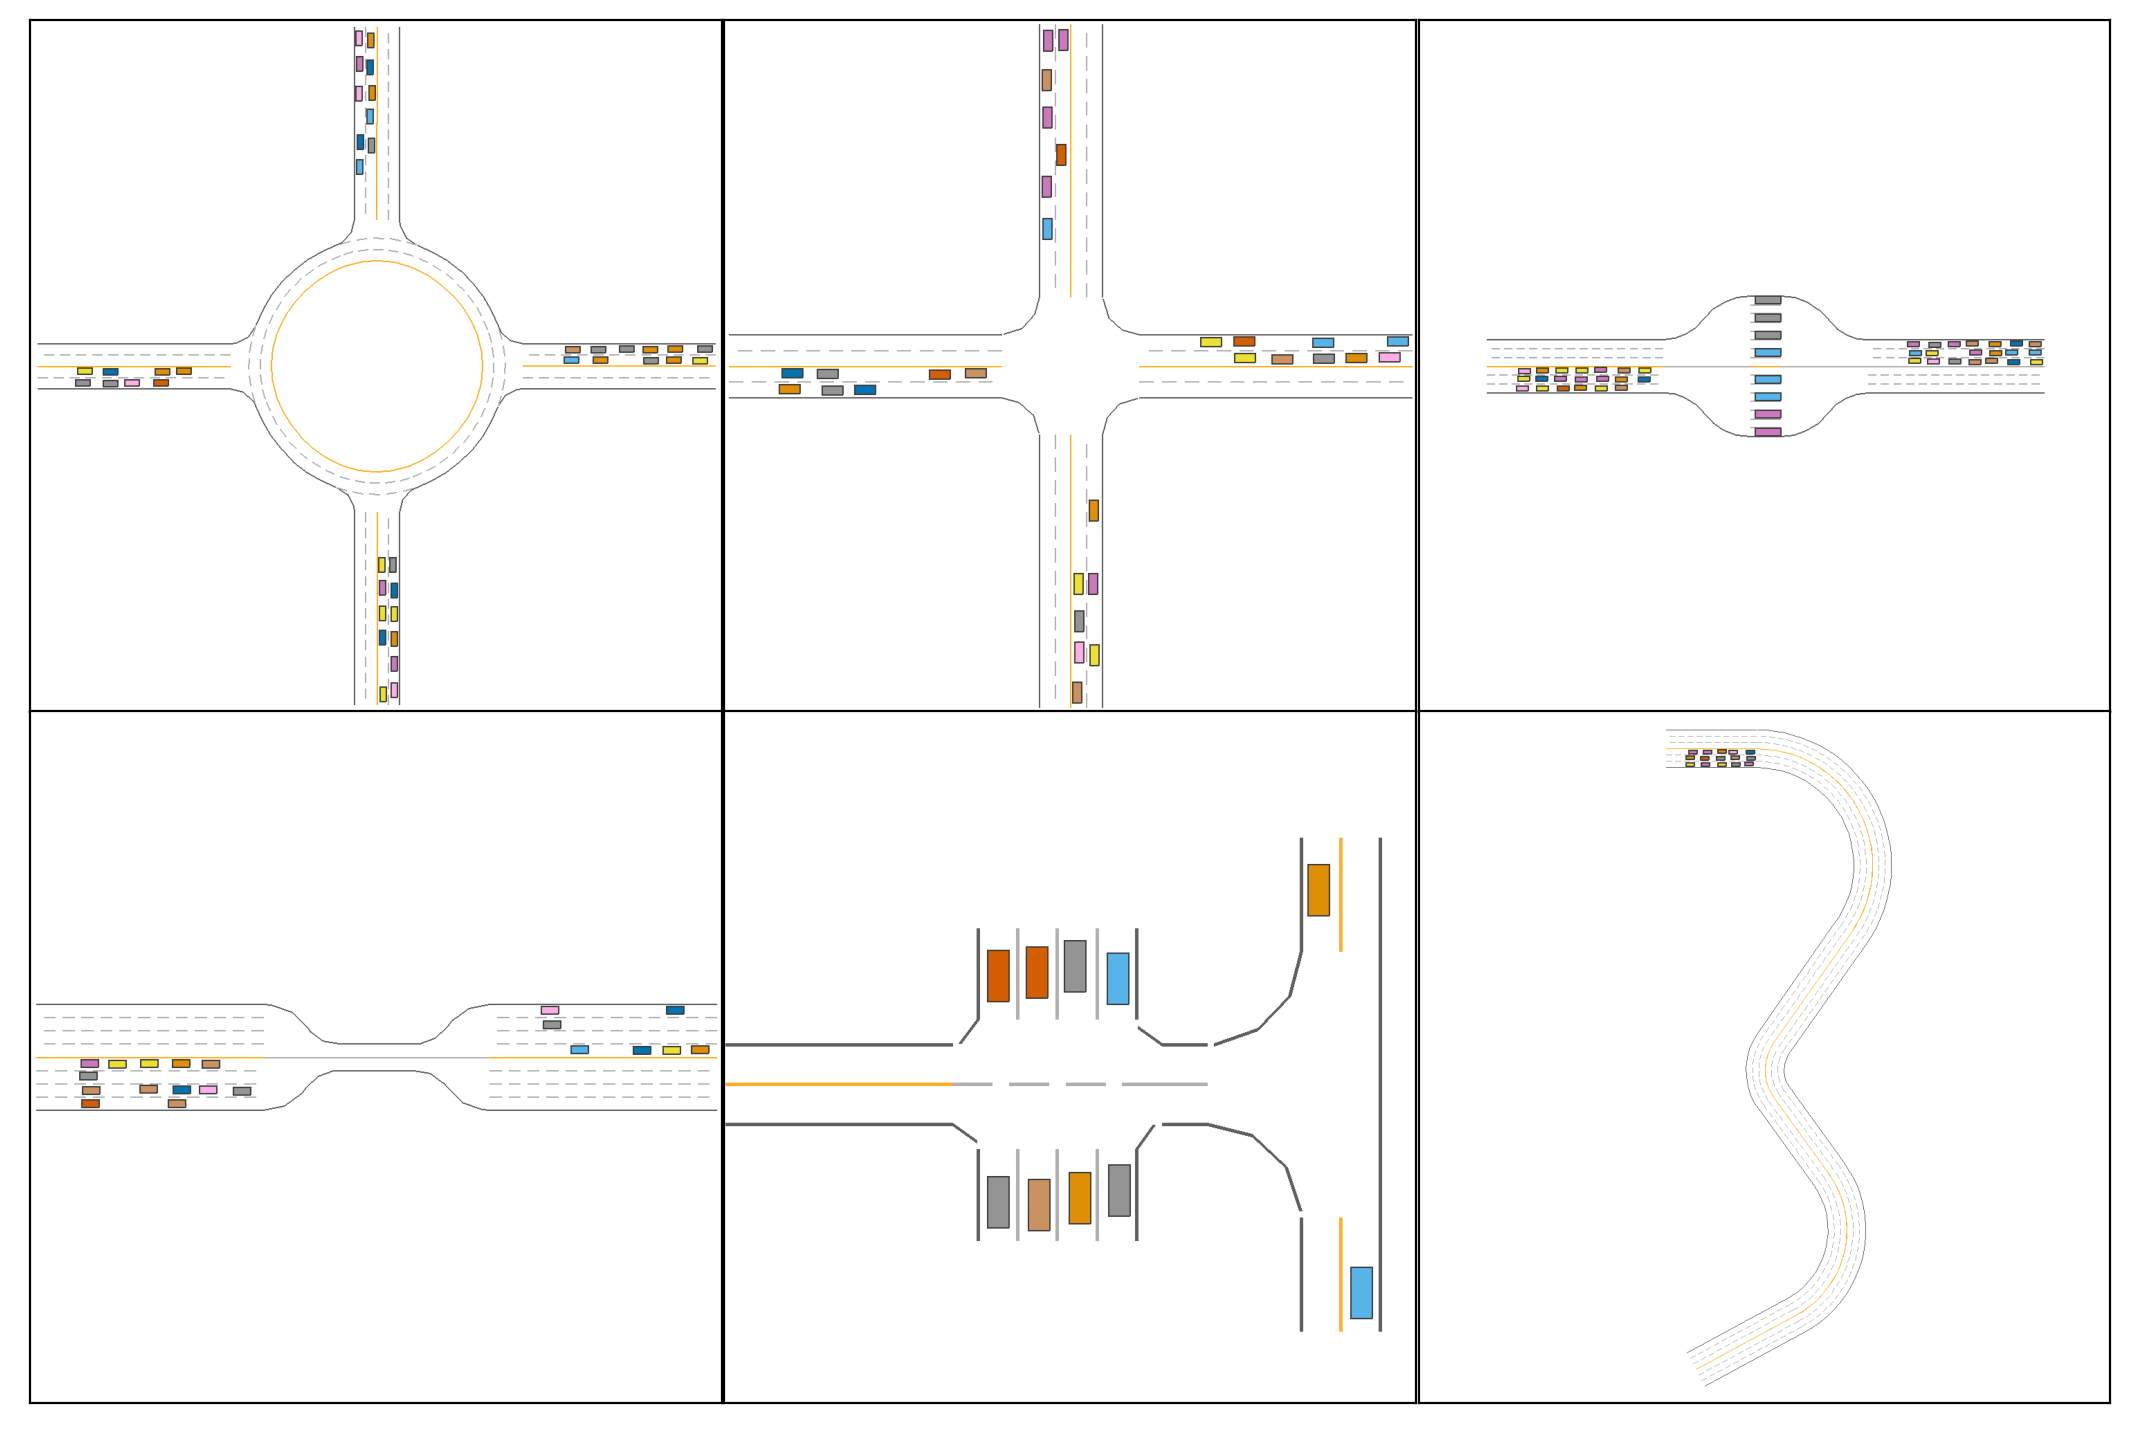

In [12]:
import matplotlib.pyplot as plt
from metadrive import (
    MultiAgentMetaDrive,
    MultiAgentTollgateEnv,
    MultiAgentBottleneckEnv,
    MultiAgentIntersectionEnv,
    MultiAgentRoundaboutEnv,
    MultiAgentParkingLotEnv
)

env_classes = dict(
    roundabout=MultiAgentRoundaboutEnv,
    intersection=MultiAgentIntersectionEnv,
    tollgate=MultiAgentTollgateEnv,
    bottleneck=MultiAgentBottleneckEnv,
    parkinglot=MultiAgentParkingLotEnv,
    pgma=MultiAgentMetaDrive
)

fig, axs = plt.subplots(2, 3, figsize=(10, 6.5), dpi=200)
plt.tight_layout(pad=-3)

for i in range(2):
    for j in range(3):
        env = list(env_classes.values())[i*3+j]({"log_level":50})
        env.reset(seed=0)
        m = env.render(mode="topdown", 
                       # get the overview of the scene
                       film_size = (1000, 1000),
                       screen_size = (1000, 1000),
                       # set camer to map center
                       camera_position=env.current_map.get_center_point(), 
                       # auto determine the number of pixels for 1 meter 
                       scaling=None,
                       # do not pop window
                       no_window=True)
        ax = axs[i][j]
        ax.imshow(m, cmap="bone")
        ax.set_xticks([])
        ax.set_yticks([])
        env.close()
plt.show()


### Number of Agents
The more agents there are, the harder the MARL task is.
You can change the number of agents in the environment with the value of field `num_agents` in the config dict. 
Note there is a upper bound for the number of agents that can be accommodated in each environment.

### Respawn
Besides, in Multi-agent environment, the controllable target vehicles consistently respawn in the scene if old target vehicles are terminated.
To limit the length of *environmental episode*, we also introduce a config `horizon = 1000` in MARL environments.
The environmental episode has a **minimal length** of `horizon` steps and the environment will stop spawning new target vehicles if this horizon is exceeded.
If you wish to disable the respawning mechanism in MARL, set the config `allow_respawn = False`. In this case, the environmental episode will terminate if no active vehicles are in the scene.

### Termination
In Multi-agent environment, the termination criterion for each vehicle is identical to that in single-agent environment.
Like the `SafeMetaDriveEnv`, we explicitly add two config to adjust the termination processing in MARL: `crash_done = True` and `out_of_road_done = True`.
They denote whether to terminate the agent episode if crash / out of road happens.
You can adjust them to change the termination condition or compose your own `done_function`.

There is another key called `delay_done` whose unit is `substep`. It denotes the terminated agent won't be recycled until `delay_done` substeps are taken. `decision_repeat` defines how many substeps will be executed in each `env.step()`. The default value is set to 5. The simulation time will progress `physics_world_step_size` when executing one `substep`. By default, the `physics_world_step_size` is `0.02`. Consequently, if we want to recycle the vehicle 10 seconds later after it is terminated, we can set `delay_done` as 50.

Feel free to change the value of these keys in the following intersection example to experience these features. 

In [ ]:
from metadrive import  MultiAgentIntersectionEnv

env = MultiAgentIntersectionEnv(dict(num_agents=40,
                                     delay_done=5, 
#                                      allow_respawn=False
                                     ))
o,_=env.reset(seed=0)
try:
    while True:
        last_o=o
        o,r,tm,_,i=env.step({agent_id: [0, 1] for agent_id in env.vehicles.keys()})
        m = env.render(mode="topdown", 
                   film_size = (1000, 1000),
                   screen_size = (1000, 1000),
                   camera_position=env.current_map.get_center_point(), 
                   scaling=None)
        if tm["__all__"]:
            break
            
        # for test only
        assert len(env.vehicles)<=env.config["num_agents"]
        if not env.config["allow_respawn"]:
            assert len(o)<=len(last_o)
finally:
    env.close()

## Real-world Environment

<video style="display:block; width:100%; height:auto; text-align: center;" autoplay="autoplay" muted="" loop="loop" playsinline="" id="real_env_video">
<source 
src="https://metadriverse.github.io/assets/scenarionet/teaser_video.mp4"
type="video/mp4">
</video>




We are developing new environments for benchmarking novel and challenging RL tasks! Any idea on the design of new tasks are welcomed!